## Airlines Tweets Sentiments
### Negative, positive and neutral tweets about airlines companies
     0 = Negative
     1 = Neutral
     2 = Positive

## Importing all the necessary libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import dython
from datetime import datetime
from dateutil import parser
import openpyxl
import spacy
sns.set_theme(style = 'whitegrid')

In [55]:
tweets = pd.read_csv('airline-tweets-sentiments.csv')
tweets.head()

,_id,tweet_text,tweet_lang,tweet_sentiment_value
0,595e60b48fcd022a715f7b7b,this @airfrance b777-300er has the oldest ifes...,en,0
1,595e60de8fcd022a715f7b7d,???? will miss my connection @airfrance https:...,en,0
2,595e61448fcd022a715f7b7f,"@airfrance lost luggage in overhead cabin, ema...",en,0
3,595e62748fcd022a715f7b83,"here's a new twist on the ""all airlines hate m...",en,0
4,595e62b28fcd022a715f7b86,@airfrance so now i might not have 3 pieces of...,en,0


In [56]:
tweets.shape

(1097, 4)

## Lets add a text label to show the sentiments

In [57]:
tweets["label"] = tweets["tweet_sentiment_value"].apply(lambda x: "Negative" if x == 0 else "Neutral" if x == 1 else "Positive" )
label_count = tweets['label'].value_counts()
label_count 

Neutral     502
Negative    406
Positive    189
Name: label, dtype: int64

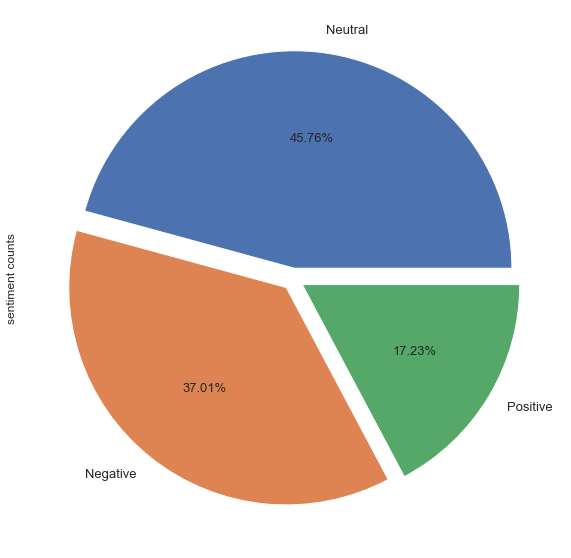

In [77]:
label_count.plot(kind = 'pie', autopct = "%.2f%%", figsize = (10,10), \
    explode = (0.05, 0.05, 0.05), fontsize = 13, label = 'sentiment counts');

## Preprocessing

## Cleaning up data, removing special characters, removing stop words of no sematic value

In [59]:
import preprocess_kgptalkie as ps  # import the cleaning package
import re # regular expression

In [60]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

## Apply the cleaning into the dataframe

In [61]:
tweets["tweet_text"] = tweets["tweet_text"].apply( lambda  x: get_clean(x))
tweets.head()

,_id,tweet_text,tweet_lang,tweet_sentiment_value,label
0,595e60b48fcd022a715f7b7b,this airfrance b7300er has the oldest ifes i h...,en,0,Negative
1,595e60de8fcd022a715f7b7d,will miss my connection airfrance,en,0,Negative
2,595e61448fcd022a715f7b7f,airfrance lost luggage in overhead cabin email...,en,0,Negative
3,595e62748fcd022a715f7b83,heres a new twist on the all airlines hate mus...,en,0,Negative
4,595e62b28fcd022a715f7b86,airfrance so now i might not have 3 pieces of ...,en,0,Negative


## Split data into X and y

In [62]:
X = tweets["tweet_text"]
y =np.array( tweets["label"])


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
vectorizer = TfidfVectorizer(max_features = 5000, ngram_range =(1,2))

In [65]:
X = vectorizer.fit_transform(X)
# y = vectorizer.fit_transform(y)

## TFIDF

In [66]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [67]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(random_state= 42 )
lgr.fit(X_train, y_train)

lgr.score(X_test, y_test), lgr.score(X_train, y_train)

(0.706060606060606, 0.9217731421121251)

In [68]:
from sklearn import svm
svm = svm.SVC(random_state= 42)
svm.fit(X_train, y_train)

svm.score(X_test, y_test), svm.score(X_train, y_train)

(0.6787878787878788, 0.9934810951760105)

In [69]:
from sklearn.ensemble import RandomForestClassifier
clf= RandomForestClassifier(n_estimators = 100, n_jobs = 1)
clf.fit(X_train, y_train)

clf.score(X_test, y_test), clf.score(X_train, y_train), 

(0.6878787878787879, 0.9973924380704041)

In [70]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(X_train, y_train)

kn.score(X_test, y_test), kn.score(X_train, y_train), 

(0.6424242424242425, 0.8161668839634941)

## Prediction and evaluation

In [110]:
y_pred =lgr.predict(X_test)
y_pred[:10]

array(['Neutral', 'Neutral', 'Negative', 'Neutral', 'Negative',
       'Negative', 'Neutral', 'Negative', 'Neutral', 'Neutral'],
      dtype=object)

In [111]:
from sklearn.metrics import classification_report, confusion_matrix

In [112]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

    Negative       0.77      0.69      0.73       124
     Neutral       0.66      0.88      0.75       153
    Positive       0.92      0.23      0.36        53

    accuracy                           0.71       330
   macro avg       0.78      0.60      0.62       330
weighted avg       0.74      0.71      0.68       330



In [113]:
cm = confusion_matrix(y_test, y_pred)
cm
cmplot = pd.DataFrame(cm , columns=["Negative","Neutral","Positive"], index=["Negative","Neutral","Positive"])
cmplot

,Negative,Neutral,Positive
Negative,86,38,0
Neutral,17,135,1
Positive,8,33,12


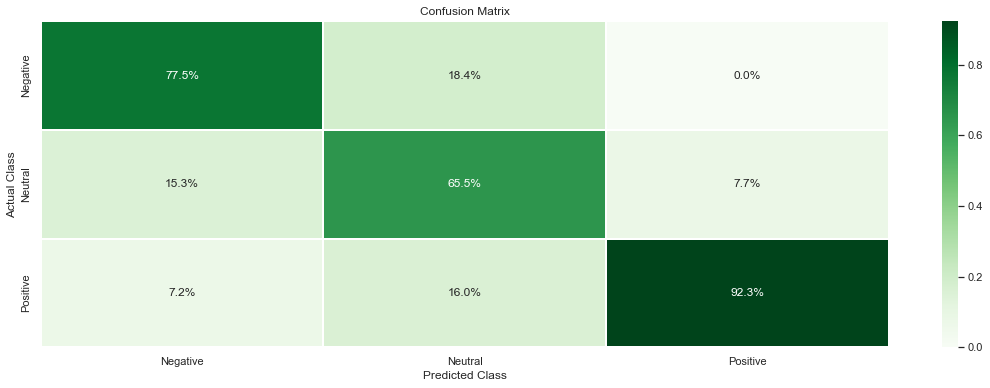

In [114]:
fig, ax = plt.subplots(figsize = (19,6))
sns.heatmap(cmplot/np.sum(cmplot), fmt= '.1%' ,linewidth=0.3, cmap = 'Greens',xticklabels = True, annot =True)
ax.set(title = 'Confusion Matrix', xlabel = 'Predicted Class', ylabel = 'Actual Class');

# lets visualize and compare on bar chart

## Save with joblib

In [115]:
import joblib
joblib.dump(svm, 'tweet_model.joblib')

['tweet_model.joblib']

In [125]:
import pickle
pickle.dump(svm, open("tweet_model.pkl", "wb"))

# loading the model to compare the actual vs predicted in terms of counts

In [116]:
loaded = joblib.load("tweet_model.joblib")

In [117]:
predicted = loaded.predict(X)

In [124]:
retest = pd.concat([tweets,pd.DataFrame(predicted, columns =['predicted'])], ignore_index = False, axis =1)
retest.sample(10)

,_id,tweet_text,tweet_lang,tweet_sentiment_value,label,predicted
547,5960a2e0745dc32c7a70a9fa,hi airfrance i cannot choosebook a seat for th...,en,1,Neutral,Neutral
495,595fef7a745dc32c7a70a8b6,airfrance airfrancemag i need urgently to get ...,en,1,Neutral,Neutral
331,5964780c4fe31f4f52a0241c,musician friends do not fly airfrance they mak...,en,0,Negative,Neutral
289,5963c8134fe31f4f52a022ed,airfrance slogan should be we will reroute you...,en,0,Negative,Negative
218,5962db354fe31f4f52a02082,airfrance lost important notebook on your af10...,en,0,Negative,Neutral
572,5960d8ca745dc32c7a70aa71,re avion byupcom work business airbus airfrance,en,1,Neutral,Neutral
909,595e739f8fcd022a715f7bdb,no airline takes care of its passengers quite ...,en,2,Positive,Positive
907,596c69d5976f440300c0fafb,woman banned from air france after slapping ai...,en,1,Neutral,Neutral
903,5965a3994fe31f4f52a02690,airfrance can you tell me why i cannot checkin...,en,1,Neutral,Neutral
491,595fdce1745dc32c7a70a87e,zaynahamarneh visitbordeaux bordeauxtourism ai...,en,1,Neutral,Neutral


In [119]:
compare = pd.concat([retest["label"].value_counts(),retest["predicted"].value_counts()], ignore_index = False, axis = 1)
compare

,label,predicted
Neutral,502,575
Negative,406,377
Positive,189,145


<AxesSubplot:>

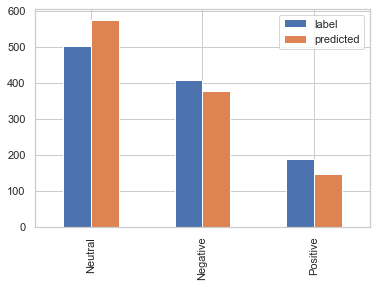

In [120]:
compare.plot(kind = "bar",)